## Introduction

The paper introduces TransformEHR, a generative encoder-decoder model with a transformer
architecture. The unique aspect it proposes is a pretraining objective aimed at predicting all
diseases and outcomes of a patient's future visit based on previous visits. 

TransformEHR was the best-performing model and outperformed BERT, LSTM, and logistic regression models by 24%, 97%, and 422% respectively. TransformEHR outperformed BERT for prediction of both single and multiple diseases/outcomes. In contrast to BERT,
TransformEHR learned the representation of each clinical variable by predicting the completediseases and outcomes with the help of cross-attention and decoder self-attention. 

TransformEHR and its pretraining strategy help the field of healthcare with EHR-based predictive modeling. By predicting the diseases and outcomes within patient visits, TransformEHR offers invaluable help for clinical decisions and intervention planning.

## Scope of Reproducibility:

Hypothesis : The TransformEHR model will perform better than other models in terms
of predictive accuracy and that the model's transformer-based architecture will enable it to
capture the nuanced relationships between different data elements within EHRs

The experiment we will be running involves using the existing TransformEHR repo found here
already pretrained on a large dataset. We will then use a different dataset that than the one it was
trained on to test its accuracy at predicting PTSD related self-harm and Pancreatic cancer rates.

The results of the paper present insights into the use cases for Pancreatic Cancer and international PTSD. However, reproducing these results was challenging due to several factors.

* Accessing the dataset utilized in the original study presented a significant challenge. The dataset's availability and accessibility were limited, impeding efforts to replicate the paper's findings accurately. This lack of easy access to crucial data hindered the replication process from the outset, highlighting the importance of transparent and readily available datasets for ensuring reproducibility in scientific research.

* An analysis of the code repository provided alongside the paper revealed critical deficiencies. Key elements essential for reproducing the experiments, such as 'dataset.py' and tokenizer information, were missing from the repository. 

Additionally, attempts to utilize pre-trained tokenizer and models were met with access errors (401), further complicating the reproduction process. These errors likely stemmed from issues related to dependencies or data access permissions.

As Part of next phase of reproducing the result of the original paper, We have taken below 2 approaches.

* Use a different preTrained model 'emilyalsentzer/Bio_ClinicalBERT'.
* Create our own Data, Task functions and Models using PyHealth package and run training and evaluation.


## Approach 1 - Implementation using PreTrained Model

### Environment

name: dlh-project
dependencies:
  - python=3.12
  - NumPy
  - PyTorch
  - scikit-learn
  - conda-forge::transformers
  - conda-forge::dataset
  - tqdm=4.62.2
  - pandas
  - packaging
  - accelerate
  - conda-forge::jupyterlab
  - conda-forge::notebook
  - conda-forge::ipywidgets

In [ ]:
#need to install this for clinical coding
# !pip install scispacy
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_sm-0.5.4.tar.gz

In [ ]:
# import  packages you need
import numpy as np
import logging
import os
from typing import Callable, Dict, List, Optional, Tuple
import csv
import json, time
from collections import defaultdict
from datetime import datetime
from itertools import combinations, islice
import pickle
import pandas as pd
import torch
import pyhealth
from pyhealth.medcode import InnerMap
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import scispacy #from above
import spacy #from above
import random

### Preprocessing Data

#### Note - Need to download these datasets in order to run below PreTrained Model

In [ ]:
notedir = './sample_data/mimic-iv/note/'
hospdir = './sample_data/mimic-iv/hosp/'
diags = pd.read_csv(hospdir + 'diagnoses_icd.csv.gz')
d_notes = pd.read_csv(notedir + 'discharge.csv.gz')
r_notes = pd.read_csv(notedir + 'radiology.csv.gz')
r_notes = r_notes.dropna(subset=['hadm_id'])
# Group radiology text into per visit 
radiology_grouped = r_notes.groupby(['subject_id','hadm_id'])['text'].apply(' '.join).reset_index()

diags10 = diags[diags.icd_version == 10]
# pancreas = diags10[diags10['icd_code'].astype(str).str.contains('C25')]
#encode all diagnoses into either times where pancreatic cancer identified or not
diags10.loc[:, 'contains_C25'] = (diags10.loc[:,'icd_code'].str.contains('C25')).astype(int)
diags_encoded = diags10.groupby(['subject_id', 'hadm_id']).agg({'contains_C25': 'max'}).reset_index()
diags_encoded.rename(columns={'contains_C25': 'icd_code'}, inplace=True)
diags_encoded['icd_code'] = diags_encoded['icd_code'].apply(lambda x: 0 if x == 0 else 1)

#just the first 512 of each if true
small_df = False

if small_df:
    merged_df = pd.merge(radiology_grouped.head(512), d_notes.head(512), on=['subject_id', 'hadm_id'], how='right')
    merged_df['text'] = merged_df['text_x'] + ' ' + merged_df['text_y']
    merged_df = merged_df.drop(columns=['text_x', 'text_y']).dropna(subset=['text'])
    merged_df = pd.merge(diags_encoded.head(512), merged_df, on=['subject_id', 'hadm_id'], how='inner').drop(columns=['note_id','note_seq','charttime','storetime', 'note_type'])
else:
    merged_df = pd.merge(radiology_grouped, d_notes, on=['subject_id', 'hadm_id'], how='right')
    merged_df['text'] = merged_df['text_x'] + ' ' + merged_df['text_y']
    merged_df = merged_df.drop(columns=['text_x', 'text_y']).dropna(subset=['text'])
    merged_df = pd.merge(diags_encoded, merged_df, on=['subject_id', 'hadm_id'], how='inner').drop(columns=['note_id','note_seq','charttime','storetime', 'note_type'])

print(merged_df.shape)
merged_df.head()

#### PreTrained Model Tokenizer

Because the clinical notes can be very long (sometimes up to 20,000 words) the tokenizer can take hours to run. We have selected a smaller subset of the data that will be pre processed for model 0. The number of rows with a record containing pancreatic cancer is around 1500, and the number containing other diseases is around 4500

In [10]:
# Increase ratio to get more non-pancreatic cancer data
ratio = .05

ones = merged_df.index[(merged_df.icd_code == 1)].tolist()
zeros = merged_df.index[(merged_df.icd_code == 0)].tolist()

N = int(ratio * len(zeros))
subset_zeros = random.sample(zeros, N)
indices = ones + subset_zeros
subset_df = merged_df.iloc[indices]
subset_df.head()

,subject_id,hadm_id,icd_code,text
69,10006029,20850584,1,"EXAMINATION: Chest radiograph, portable AP up..."
70,10006029,25426298,1,INDICATION: ___ year old man with metastatic ...
74,10006431,25589898,1,EXAMINATION: CTA ABD AND PELVIS\n\nINDICATION...
75,10006431,27715811,1,EXAMINATION: CHEST (PA AND LAT)\n\nINDICATION...
76,10006431,28771670,1,"INDICATION: ___ with upper abdominal pain, hi..."


The process to tokenise first begins by removing some common fluff that exists in the text records. Then run the text through scispacy- a biomedical text processing library which will remove any extranenous filler words and return a more simplifed sequence. Then, using the predefined tokenizer from [Bio_ClinicalBERT](https://huggingface.co/emilyalsentzer/Bio_ClinicalBERT) the text in each row is tokenized and either padded or in a few cases truncated to a max length of 8192. (This whole process takes about 2 seconds per row)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
nlp = spacy.load("en_core_sci_sm")
def process_row(row):
    text = row['text']
    text = text.replace('\n', '')
    text = text.replace('___','')
    text = text.replace('Name:                   Unit No:    Admission Date:                Discharge Date:    Date of Birth:', '')
    doc = nlp(text)
    ents = doc.ents
    t = ''
    for s in ents:
        t += s.text
        t += ' '
    
    t = t.replace('=','')
    tok = tokenizer(t, return_tensors="pt", max_length=8192, truncation=True, padding='max_length')
    return tok

tts = subset_df.apply(process_row, axis=1)

inps = torch.stack([tok['input_ids'] for tok in tts])
inps = inps.squeeze(1).tolist()
masks = torch.stack([tok['attention_mask'] for tok in tts])
masks = masks.squeeze(1).tolist()
subset_df['encoded_text'] = inps
subset_df['masks'] = masks
subset_df.drop(columns='text').to_pickle('./subset_df.pkl')


#### the tokenised pickle data can be [downloaded here](https://drive.google.com/file/d/1OIG8JaMfg7x5Cl9Losf8a_SJ7smxDic0/view?usp=drive_link) and loaded like this in lieu of running more pre processing:


In [5]:
df = pd.read_pickle('subset_df.pkl')
print(df.shape)
df.head()

(6039, 5)


,subject_id,hadm_id,icd_code,encoded_text,masks
69,10006029,20850584,1,"[101, 8179, 2229, 2070, 15241, 170, 1643, 1275...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
70,10006029,25426298,1,"[101, 12754, 1299, 27154, 27372, 22572, 5326, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
74,10006431,25589898,1,"[101, 8179, 172, 1777, 170, 1830, 1181, 185, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
75,10006431,27715811,1,"[101, 8179, 185, 1161, 5837, 7563, 13335, 2566...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
76,10006431,28771670,1,"[101, 12754, 3105, 24716, 2489, 1607, 13316, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


### PreTrained Model


The base model used for the pretrained model comes from the [Bio_ClinicalBERT](https://huggingface.co/emilyalsentzer/Bio_ClinicalBERT). This model was trained on ~880 million words from discharge summary notes from the [mimic III dataset](https://mimic.mit.edu/). Their base model can be loaded as follows: 


In [ ]:
model = BertForSequenceClassification.from_pretrained('emilyalsentzer/Bio_ClinicalBERT', num_labels=2)

### PreTrained Model fine tuning

Following the [original paper](https://www.nature.com/articles/s41467-023-43715-z), the training and testing data was split into the ratio of 95-5 due to memory issues the batch size was reduced to 16 rather than using the original of 48.

the model can only handle a max_length of 512, therefore chunking was implemented for better training capture. The model was trained over 5 epochs on a google collab T4 GPU with 15 GB of memory with each epoch taking roughly 12 minutes for a total training time of around an hour.


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_ids = df['encoded_text'].tolist()
attention_masks = df['masks'].tolist()
labels = df['icd_code'].tolist()

batch_size = 16

ids = torch.tensor(input_ids).to(device)
masks = torch.tensor(attention_masks).to(device)
labels = torch.tensor(labels).to(device)

dataset = TensorDataset(ids, masks, labels)

train_size = int(0.95 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

max_length = 512
chunk_size = 512


In [ ]:
epochs = 5
for epoch in range(epochs):
    model.train()
    for batch in train_dataloader:
        input_ids_batch, attention_masks_batch, labels_batch = batch
        optimizer.zero_grad()

        # chunk
        chunk_logits = []
        for i in range(0, len(input_ids_batch), chunk_size):
            input_ids_chunk = input_ids_batch[:,i:i+chunk_size].to(device)
            attention_masks_chunk = attention_masks_batch[:,i:i+chunk_size].to(device)
            logits = model(input_ids=input_ids_chunk, attention_mask=attention_masks_chunk).logits
            chunk_logits.append(logits)

        logits = torch.mean(torch.stack(chunk_logits), dim=0)

        loss = criterion(logits, labels_batch)
        loss.backward()
        optimizer.step()

#### This model was saved and [upload here](https://drive.google.com/file/d/1jehT4uyz6465kX5Ho-ddn1qikzyso5vV/view?usp=drive_link) This tuned model can be loaded as follows:

In [18]:
model = BertForSequenceClassification.from_pretrained('emilyalsentzer/Bio_ClinicalBERT', num_labels=2)
path = './5_tuned_model.pth'
model.load_state_dict(torch.load(path, map_location=torch.device(device)))


### Pretrained Model evaluation

The model was then tested on the remaining 5% of the dataset using the same chunking method as was used in training and yielded the following scores:

Accuracy: 0.9511589403973509

Precision: 0.907258064516129

Recall: 0.8620689655172413

F1-score: 0.8840864440078585


In [20]:
# Evaluation loop
model = BertForSequenceClassification.from_pretrained('emilyalsentzer/Bio_ClinicalBERT', num_labels=2)
path = './5_tuned_model.pth'
model.load_state_dict(torch.load(path, map_location=torch.device(device)))

model.eval()
predictions = []
true_labels = []

max_length = 512
chunk_size = 512

with torch.no_grad():
    for batch in test_dataloader:
        input_ids_batch, attention_masks_batch, labels_batch = batch
                # chunk
        chunk_logits = []
        for i in range(0, len(input_ids_batch), chunk_size):
            input_ids_chunk = input_ids_batch[:,i:i+chunk_size]
            attention_masks_chunk = attention_masks_batch[:,i:i+chunk_size]
            logits = model(input_ids=input_ids_chunk, attention_mask=attention_masks_chunk).logits
            chunk_logits.append(logits)
        logits = torch.mean(torch.stack(chunk_logits), dim=0)
        _, predicted = torch.max(logits, dim=1)
        predictions.extend(predicted.tolist())
        true_labels.extend(labels_batch.tolist())


In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.9511589403973509
Precision: 0.907258064516129
Recall: 0.8620689655172413
F1-score: 0.8840864440078585


## Approach 2 -  Implementation with PyHealth Package



### Environment

In [2]:
import csv
import pandas as pd
import torch
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from pyhealth.datasets import MIMIC4Dataset
from pyhealth.datasets.splitter import split_by_patient
from pyhealth.datasets import split_by_patient, get_dataloader
from pyhealth.models import Transformer
from pyhealth.trainer import Trainer
from pyhealth.metrics import multilabel_metrics_fn, binary_metrics_fn

import matplotlib.pyplot as plt
from sklearn import metrics


#### Preprocessing of Data

* Select records with ICD-VERSION = 10 from diagnosis_icd.csv

In [1]:


data_df = pd.read_csv('./mimic-iv-2.2/hosp/diagnoses_icd.csv.gz', nrows=None, compression='gzip',
            dtype={'subject_id': str, 'hadm_id': str, 'icd_code': str, 'icd_version': str},
            on_bad_lines='skip')


# Select records with ICD-VERSION =10

data_df_icd_10 = data_df[data_df['icd_version'] == "10"]

dir_path = './mimic-iv-2.2/hosp/diagnosis_icd10.csv'

data_df_icd_10.to_csv(dir_path, index=False)

print('After preprocessing Data in diagnosis_icd')
print(data_df_icd_10.iloc[:3])


After preprocessing Data in diagnosis_icd
   subject_id   hadm_id  seq_num icd_code icd_version
40   10000084  23052089        1    G3183          10
41   10000084  23052089        2    F0280          10
42   10000084  23052089        3     R441          10


### In Below Section we'll be showing 3 models:

#### Model-1 : Run Multilabel prediction using dataset with feature keys: Diagnosis code, procedure code and drugs prescribed.
#### Model-2 : Run Multilabel prediction using dataset with feature key - Diagnosis code.
#### Model-3 : Run Binary prediction using dataset with feature key - Diagnosis code.

### Dataset Preparation

In [2]:
import warnings
warnings.filterwarnings('ignore')

from pyhealth.datasets import MIMIC4Dataset

### Dataset with information such as diagnosis code, procedure code, prescription history of past visits of patients

In [3]:
# Dataset with Diagnosis code, procedure code and drugs prescribed
mimic4_ds = MIMIC4Dataset(
        root="./mimic-iv-2.2/hosp",
        tables=["diagnoses_icd", "procedures_icd", "prescriptions"],
        code_mapping={"NDC": ("ATC")},
        refresh_cache=False,
)

# Show the statistics below.
mimic4_ds.stat()


Statistics of base dataset (dev=False):
	- Dataset: MIMIC4Dataset
	- Number of patients: 180733
	- Number of visits: 431231
	- Number of visits per patient: 2.3860
	- Number of events per visit in diagnoses_icd: 4.6134
	- Number of events per visit in procedures_icd: 1.5518
	- Number of events per visit in prescriptions: 54.2354



'\nStatistics of base dataset (dev=False):\n\t- Dataset: MIMIC4Dataset\n\t- Number of patients: 180733\n\t- Number of visits: 431231\n\t- Number of visits per patient: 2.3860\n\t- Number of events per visit in diagnoses_icd: 4.6134\n\t- Number of events per visit in procedures_icd: 1.5518\n\t- Number of events per visit in prescriptions: 54.2354\n'

### Dataset with information such as - diagnosis code history of past visits of patients

In [4]:
# Dataset with Diagnosis code
mimic4_ds_diag = MIMIC4Dataset(
        root="./mimic-iv-2.2/hosp",
        tables=["diagnoses_icd"],
        refresh_cache=False,
)

# Show the statistics below.
mimic4_ds_diag.stat()


Statistics of base dataset (dev=False):
	- Dataset: MIMIC4Dataset
	- Number of patients: 180733
	- Number of visits: 431231
	- Number of visits per patient: 2.3860
	- Number of events per visit in diagnoses_icd: 4.6134



'\nStatistics of base dataset (dev=False):\n\t- Dataset: MIMIC4Dataset\n\t- Number of patients: 180733\n\t- Number of visits: 431231\n\t- Number of visits per patient: 2.3860\n\t- Number of events per visit in diagnoses_icd: 4.6134\n'

## Task Functions

#### Task Function 1 - Task Function for diagnosis recommendation.
#### This function will create dataset sample to be used in diagnosis recommendation of future visits using past visit's history.

In [5]:
def condition_recommendation_mimic4_fn(patient):
    samples = []
    for visit in patient:

        # step 1: obtain visit-level information, conditions, procedures, and drugs
        conditions = visit.get_code_list(table="diagnoses_icd")
        procedures = visit.get_code_list(table="procedures_icd")
        drugs = visit.get_code_list(table="prescriptions")
      
        # step 2: exclusion criteria: cohort selection
        if len(conditions) * len(procedures) * len(drugs) == 0: continue

        # step 3: assemble the sample
        # REMEMBER: the key here will be the "feature_keys" and "label_key" for initializing the downstream model
        samples.append(
            {
                "visit_id": visit.visit_id,
                "patient_id": patient.patient_id,
                "condition_hist": conditions,
                "procedures": procedures,
                "drugs": drugs,
                "condition": conditions,
            }
        )

    # step 4: patient-level cohort selection and other process
    # exclude patients with less than 2 visit
    if len(samples) < 2:
        return []

    """ 
    Add historical visit (use "conditions" key as an example)
        before this step:
            samples[0]["conditions"]: 1st visit
            samples[1]["conditions"]: 2nd visit
            samples[2]["conditions"]: 3rd visit
            ...
        
        after this step:
            samples[0]["conditions"]: [1st visit]
            samples[1]["conditions"]: [1st visit, 2nd visit]
            samples[2]["conditions"]: [1st visit, 2nd visit, 3rd visit]
            ...
    """
    # Note - For first visit - condition and condition history both will be empty list
    samples[0]["condition"] = []
    samples[0]["condition_hist"] = [samples[0]["condition_hist"]]
    samples[0]["procedures"] = [samples[0]["procedures"]]
    samples[0]["drugs"] = [samples[0]["drugs"]]

    for i in range(1, len(samples)):
        samples[i]["condition_hist"] = samples[i - 1]["condition_hist"] + [
            samples[i]["condition_hist"]
        ]
        samples[i]["procedures"] = samples[i - 1]["procedures"] + [
            samples[i]["procedures"]
        ]
        samples[i]["drugs"] = samples[i - 1]["drugs"] + [
            samples[i]["drugs"]
        ]
 
    for i in range(len(samples)):
        samples[i]["condition_hist"][i] = []

    return samples

#### Task Function 2 - Task Function for diagnosis recommendation using only history of diagnosis from past visits..
#### This function will create dataset sample to be used in diagnosis recommendation of future visits using past visit's history.

In [6]:
def condition_recommendation_mimic4_fn_diag(patient):
    samples = []
    for visit in patient:

        # step 1: obtain visit-level information, conditions, procedures, and drugs
        conditions = visit.get_code_list(table="diagnoses_icd")

        # step 2: exclusion criteria: cohort selection
        if len(conditions) == 0: continue

        # step 3: assemble the sample
        # REMEMBER: the key here will be the "feature_keys" and "label_key" for initializing the downstream model
        samples.append(
            {
                "visit_id": visit.visit_id,
                "patient_id": patient.patient_id,
                "condition_hist": conditions,
                "condition": conditions,
            }
        )

    # step 4: patient-level cohort selection and other process
    # exclude patients with less than 2 visit
    if len(samples) < 2:
        return []

    """ 
    Add historical visit (use "conditions" key as an example)
        before this step:
            samples[0]["conditions"]: 1st visit
            samples[1]["conditions"]: 2nd visit
            samples[2]["conditions"]: 3rd visit
            ...
        
        after this step:
            samples[0]["conditions"]: [1st visit]
            samples[1]["conditions"]: [1st visit, 2nd visit]
            samples[2]["conditions"]: [1st visit, 2nd visit, 3rd visit]
            ...
    """
    # Note - For first visit - condition and condition history both will be empty list
    samples[0]["condition"] = []
    samples[0]["condition_hist"] = [samples[0]["condition_hist"]]

    for i in range(1, len(samples)):
        samples[i]["condition_hist"] = samples[i - 1]["condition_hist"] + [
            samples[i]["condition_hist"]
        ]

    for i in range(len(samples)):
        samples[i]["condition_hist"][i] = []

    return samples

#### Task Function 3 - Task Function for diagnosis recommendation related to Pancreatic Cancer using only history of diagnosis from past visits.
#### This function will create dataset sample to be used in diagnosis recommendation of future visits using past visit's history.

In [7]:
def condition_recommendation_mimic4_fn_diag_c25(patient):
    samples = []
    for visit in patient:

        # step 1: obtain visit-level information, conditions, procedures, and drugs
        conditions = visit.get_code_list(table="diagnoses_icd")

        c25_cond = 0

        for condition in conditions:
            if condition[:3] != 'C25': continue
            else:
                c25_cond = 1


        # step 2: exclusion criteria: cohort selection
       
        if len(conditions) == 0: continue
            

        # step 3: assemble the sample
        # REMEMBER: the key here will be the "feature_keys" and "label_key" for initializing the downstream model
        # Set label to True if any diagnosis code start with 'C25' present in visit history.
        samples.append(
            {
                "visit_id": visit.visit_id,
                "patient_id": patient.patient_id,
                "condition_hist": conditions,
                "label": c25_cond,
            }
        )

    # step 4: patient-level cohort selection and other process
    # exclude patients with less than 2 visit
    if len(samples) < 2:
        return []

    """ 
    Add historical visit (use "conditions" key as an example)
        before this step:
            samples[0]["conditions"]: 1st visit
            samples[1]["conditions"]: 2nd visit
            samples[2]["conditions"]: 3rd visit
            ...
        
        after this step:
            samples[0]["conditions"]: [1st visit]
            samples[1]["conditions"]: [1st visit, 2nd visit]
            samples[2]["conditions"]: [1st visit, 2nd visit, 3rd visit]
            ...
    """

    samples[0]["condition_hist"] = [samples[0]["condition_hist"]]

    for i in range(1, len(samples)):
        samples[i]["condition_hist"] = samples[i - 1]["condition_hist"] + [
            samples[i]["condition_hist"]
        ]

    return samples

#### Task Functions to create Test Datasets 

#### Task Function 4 - Task Function for diagnosis recommendation related to Pancreatic Cancer using history of Diagnosis, Procedure and Drugs Prescribed from past visits.
#### This function will create test dataset sample to be used in diagnosis recommendation of future visits using past visit's history.

In [8]:
def condition_recommendation_mimic4_fn_c25(patient):
    samples = []
    for visit in patient:

        # step 1: obtain visit-level information, conditions, procedures, and drugs
        conditions = visit.get_code_list(table="diagnoses_icd")
        procedures = visit.get_code_list(table="procedures_icd")
        drugs = visit.get_code_list(table="prescriptions")

        # step 2: Select visits with diagnosis code starts with C25
        c25_cond ='n'

        for condition in conditions:
            if condition[:3] != 'C25': continue
            else:
                c25_cond = 'y'
        if c25_cond == 'n':
            conditions = []


        # step 3: exclusion criteria: cohort selection

        if len(conditions) * len(procedures) * len(drugs) == 0: continue

        # step 4: assemble the sample
        # REMEMBER: the key here will be the "feature_keys" and "label_key" for initializing the downstream model
        samples.append(
            {
                "visit_id": visit.visit_id,
                "patient_id": patient.patient_id,
                "condition_hist": conditions,
                "procedures": procedures,
                "drugs": drugs,
                "condition": conditions,
            }
        )

    # step 5: patient-level cohort selection and other process
    # exclude patients with less than 2 visit
    if len(samples) < 2:
        return []

    """ 
    Add historical visit (use "conditions" key as an example)
        before this step:
            samples[0]["conditions"]: 1st visit
            samples[1]["conditions"]: 2nd visit
            samples[2]["conditions"]: 3rd visit
            ...
        
        after this step:
            samples[0]["conditions"]: [1st visit]
            samples[1]["conditions"]: [1st visit, 2nd visit]
            samples[2]["conditions"]: [1st visit, 2nd visit, 3rd visit]
            ...
    """
    samples[0]["condition"] = []
    samples[0]["condition_hist"] = [samples[0]["condition_hist"]]
    samples[0]["procedures"] = [samples[0]["procedures"]]
    samples[0]["drugs"] = [samples[0]["drugs"]]

    for i in range(1, len(samples)):
        samples[i]["condition_hist"] = samples[i - 1]["condition_hist"] + [
            samples[i]["condition_hist"]
        ]
        samples[i]["procedures"] = samples[i - 1]["procedures"] + [
            samples[i]["procedures"]
        ]
        samples[i]["drugs"] = samples[i - 1]["drugs"] + [
            samples[i]["drugs"]
        ]

    for i in range(len(samples)):
        samples[i]["condition_hist"][i] = []

    return samples

#### Task Function 5 - Task Function for diagnosis recommendation related to Pancreatic Cancer using only history of diagnosis from past visits. This will add data samples with and without Pancreatic Cancer Diagnosis. So that model performance will be done more accurately.
#### This function will create test dataset sample to be used in diagnosis recommendation of future visits using past visit's history.

In [9]:
def condition_recommendation_mimic4_fn_c25_test(patient):
    samples = []

    for visit in patient:

        # step 1: obtain visit-level information, conditions, procedures, and drugs
        conditions = visit.get_code_list(table="diagnoses_icd")

        # step 2: Select mixed samples. 
        #   Select visit data with atleast 2 visits has diagnosis code starts with 'C25'. 

        c25_cond =0

        if len(samples) < 3:

            for condition in conditions:
                if condition[:3] != 'C25': continue
                else:
                    c25_cond = 1
            if c25_cond == 0:
                conditions = []


        # step 3: exclusion criteria: cohort selection
        if len(conditions) == 0: continue

        # step 3: assemble the sample
        # REMEMBER: the key here will be the "feature_keys" and "label_key" for initializing the downstream model
        samples.append(
            {
                "visit_id": visit.visit_id,
                "patient_id": patient.patient_id,
                "condition_hist": conditions,
                "label": c25_cond,
            }
        )

    # step 4: patient-level cohort selection and other process
    # exclude patients with less than 2 visit
    if len(samples) < 2:
        return []

    """ 
    Add historical visit (use "conditions" key as an example)
        before this step:
            samples[0]["conditions"]: 1st visit
            samples[1]["conditions"]: 2nd visit
            samples[2]["conditions"]: 3rd visit
            ...
        
        after this step:
            samples[0]["conditions"]: [1st visit]
            samples[1]["conditions"]: [1st visit, 2nd visit]
            samples[2]["conditions"]: [1st visit, 2nd visit, 3rd visit]
            ...
    """

    samples[0]["condition_hist"] = [samples[0]["condition_hist"]]
    
    for i in range(1, len(samples)):
        samples[i]["condition_hist"] = samples[i - 1]["condition_hist"] + [
            samples[i]["condition_hist"] ]

    return samples


### Create Training, Valuation and Test Datasets and Dataloaders

#### Create datasets and dataloaders for Model - 1 using Task Function 1 - "condition_recommendation_mimic4_fn"

In [10]:
import numpy as np
from pyhealth.datasets.splitter import split_by_patient
from pyhealth.datasets import split_by_patient, get_dataloader

np.random.seed(1234)

In [11]:
dataset = mimic4_ds.set_task(task_fn=condition_recommendation_mimic4_fn)

print ('For Model 1 - Sample data 1')
print(dataset.samples[1])
print ('For Model 1 - Sample data 2')
print(dataset.samples[2])

# data split
train_dataset, val_dataset, test_dataset = split_by_patient(dataset, [0.8, 0.1, 0.1])

# create dataloaders (they are <torch.data.DataLoader> object)
train_loader = get_dataloader(train_dataset, batch_size=64, shuffle=True)
val_loader = get_dataloader(val_dataset, batch_size=64, shuffle=False)
test_loader = get_dataloader(test_dataset, batch_size=64, shuffle=False)

Generating samples for condition_recommendation_mimic4_fn: 100%|████████████████████████████████████████████████████████████| 180733/180733 [00:47<00:00, 3817.20it/s]


For Model 1 - Sample data 1
{'visit_id': '26840593', 'patient_id': '10001401', 'condition_hist': [['C675', 'I10', 'D259', 'Z87891', 'E785', 'E890'], []], 'procedures': [['0TTB4ZZ', '07BC4ZX', '0UT9FZZ', '0UTC7ZZ', '0UT2FZZ', '0UBG4ZZ', '0T1807C', '8E0W4CZ'], ['02HV33Z', '3E0436Z', '0W9J30Z']], 'drugs': [['B01AB01', 'A06AA02', 'N02BE01', 'G01AF20', 'N02AA01', 'M01AB15', 'J01XD01', 'J01DB04', 'A04AA01', 'H03AA01', 'B05BA03', 'C05BB56', 'N02AA05', 'N02AA03', 'C10AA05', 'A02BC02', 'B01AB05', 'R02AX02', 'M01AE01', 'A02AB01', 'A02AB02', 'A02AA04', 'G04BX01', 'A06AB02', 'A06AD10', 'A06AG02', 'R06AD02', 'B05XA03', 'N02BE05', 'D08AE03', 'R02AD01', 'J01XE01'], ['B01AB05', 'B05BA03', 'C05BB56', 'H03AA01', 'B01AB01', 'C01BB01', 'N02BE01', 'N02BE05', 'A02BC02', 'D08AE03', 'C05AD01', 'D04AB01', 'N05BA06', 'N02AA03', 'A03FA01', 'M01AB15', 'B05XA03', 'J01DD04', 'A06AB02', 'A06AD10', 'A06AG02', 'A02BC01', 'J01EE01', 'A06AA02', 'J01MA02', 'A06AB06', 'P01AB01', 'A09AA01', 'A08AA56', 'G04BE52', 'N02AA59',

#### Create datasets and dataloaders for Model - 2 using Task Function 2 - "condition_recommendation_mimic4_fn_diag"

In [12]:
dataset_diag = mimic4_ds_diag.set_task(task_fn=condition_recommendation_mimic4_fn_diag)

print ('For Model 2 - Sample data 1')
print(dataset_diag.samples[1])
print ('For Model 2 - Sample data 2')
print(dataset_diag.samples[2])

# data split
train_dataset_diag, val_dataset_diag, test_dataset_diag = split_by_patient(dataset_diag, [0.8, 0.1, 0.1])

# create dataloaders (they are <torch.data.DataLoader> object)
train_loader_diag = get_dataloader(train_dataset_diag, batch_size=64, shuffle=True)
val_loader_diag = get_dataloader(val_dataset_diag, batch_size=64, shuffle=False)
test_loader_diag = get_dataloader(test_dataset_diag, batch_size=64, shuffle=False)

Generating samples for condition_recommendation_mimic4_fn_diag: 100%|█████████████████████████████████████████████████████| 180733/180733 [00:01<00:00, 124337.76it/s]


For Model 2 - Sample data 1
{'visit_id': '29888819', 'patient_id': '10000084', 'condition_hist': [['G3183', 'F0280', 'R441', 'R296', 'E785', 'Z8546'], []], 'condition': ['R4182', 'G20', 'F0280', 'R609', 'E785', 'Z8546']}
For Model 2 - Sample data 2
{'visit_id': '22927623', 'patient_id': '10000117', 'condition_hist': [[]], 'condition': []}


#### Create datasets and dataloaders for Model - 3 using Task Function 3 - "condition_recommendation_mimic4_fn_diag_c25"

In [13]:
dataset_diag_c25 = mimic4_ds_diag.set_task(task_fn=condition_recommendation_mimic4_fn_diag_c25)


print ('For Model 3 - Sample data 1')
print(dataset_diag_c25.samples[1])
print ('For Model 3 - Sample data 2')
print(dataset_diag_c25.samples[2])

# data split
train_dataset_diag_c25, val_dataset_diag_c25, test_dataset_diag_c25 = split_by_patient(dataset_diag_c25, [0.8, 0.1, 0.1])

# create dataloaders (they are <torch.data.DataLoader> object)
train_loader_diag_c25 = get_dataloader(train_dataset_diag_c25, batch_size=64, shuffle=True)
val_loader_diag_c25 = get_dataloader(val_dataset_diag_c25, batch_size=64, shuffle=False)
test_loader_diag_c25 = get_dataloader(test_dataset_diag_c25, batch_size=64, shuffle=False)

Generating samples for condition_recommendation_mimic4_fn_diag_c25: 100%|█████████████████████████████████████████████████| 180733/180733 [00:00<00:00, 222660.61it/s]


For Model 3 - Sample data 1
{'visit_id': '29888819', 'patient_id': '10000084', 'condition_hist': [['G3183', 'F0280', 'R441', 'R296', 'E785', 'Z8546'], ['R4182', 'G20', 'F0280', 'R609', 'E785', 'Z8546']], 'label': 0}
For Model 3 - Sample data 2
{'visit_id': '22927623', 'patient_id': '10000117', 'condition_hist': [['R1310', 'R0989', 'K31819', 'K219', 'K449', 'F419', 'I341', 'M810', 'Z87891']], 'label': 0}


#### Create Test datasets and dataloaders for Model - 1 using Task Function 4 - "condition_recommendation_mimic4_fn_c25"

In [14]:
dataset_c25 = mimic4_ds.set_task(task_fn=condition_recommendation_mimic4_fn_c25)

print ('For Model 1 - Sample Test data 1')
print(dataset_c25.samples[1])
print('Test Sample size: ', len(dataset_c25))

test_loader_c25 = get_dataloader(dataset_c25, batch_size=64, shuffle=False)

Generating samples for condition_recommendation_mimic4_fn_c25: 100%|███████████████████████████████████████████████████████| 180733/180733 [00:05<00:00, 34951.04it/s]

For Model 1 - Sample Test data 1
{'visit_id': '25589898', 'patient_id': '10006431', 'condition_hist': [['G893', 'Z66', 'K8580', 'E43', 'C250', 'C787', 'C7900', 'I959', 'K219', 'Z681', 'I10', 'E049', 'E7800', 'K5900'], []], 'procedures': [['3E0T3GC'], ['0FBG3ZX']], 'drugs': [['N02AA03', 'A06AB06', 'A06AA02', 'G01AF20', 'A06AD15', 'C09AA03', 'B05XA01', 'A12CC02', 'B05XA05', 'V04CC02', 'B01AB01', 'N05AB04', 'A04AA01', 'A02BC03', 'N05AA01', 'N02AA05', 'A06AB02', 'A06AD10', 'A06AG02', 'B05BA03', 'C05BB56', 'B05XA03', 'N02BE51', 'N02BE01', 'C05AD01', 'D04AB01', 'A02AA04', 'G04BX01'], ['G01AF20', 'N02AA01', 'A04AA01', 'B01AB01', 'C09AA03', 'C10AC01', 'A02BC01', 'A11DA01', 'A12BA01', 'A06AA02', 'A06AB06', 'A06AD15']], 'condition': ['C250', 'H905', 'I10', 'E042', 'K838', 'L298', 'K219', 'D509', 'G4700', 'Z800']}
Test Sample size:  699


#### Create Test datasets and dataloaders for Model - 3 using Task Function 5 - "condition_recommendation_mimic4_fn_c25_test"

In [15]:
dataset_c25_test = mimic4_ds_diag.set_task(task_fn=condition_recommendation_mimic4_fn_c25_test)

print ('For Model 3 - Sample Test data 1')
print(dataset_c25_test.samples[1])
print('Test Sample size: ', len(dataset_c25_test))

test_loader_c25_test = get_dataloader(dataset_c25_test, batch_size=64, shuffle=False)

Generating samples for condition_recommendation_mimic4_fn_c25_test: 100%|█████████████████████████████████████████████████| 180733/180733 [00:01<00:00, 108760.56it/s]

For Model 3 - Sample Test data 1
{'visit_id': '25426298', 'patient_id': '10006029', 'condition_hist': [['N179', 'C221', 'C259', 'C7802', 'C7801', 'I10', 'E785', 'F419', 'N400', 'I129', 'E1122', 'N189', 'Z7984', 'Z87891', 'T464X5A', 'Y929', 'D6481', 'T451X5A', 'E039', 'Z794', 'Z905', 'I959', 'E860', 'Z7901'], ['C786', 'E43', 'C250', 'C787', 'C781', 'C771', 'N179', 'E871', 'G893', 'K8681', 'Z85528', 'Z8589', 'Z905', 'Z66', 'Z515', 'E1122', 'I129', 'N189', 'Z794', 'E7849', 'N400', 'K529', 'Z87891', 'K117', 'D630', 'E860', 'Z6826', 'Z7902', 'B001', 'F419', 'G4700', 'R739', 'T380X5A', 'Y92230', 'K5900']], 'label': 1}
Test Sample size:  1295


### Model Details

### Model 1 : Multilabel Recommendation with dataset with feature keys # Diagnostic history, Procedure History and Drugs prescribed history

### Model Architecture:
The model is based on the Transformer architecture, which is commonly used in natural language processing tasks.

### Input Features:
The model takes three types of input features: "condition_hist", "procedures", and "drugs". Each input feature is embedded using an embedding layer. The embedding size is 128 for each feature type.

### Output Label:
The task is multilabel classification, where the model predicts one or more labels for each input sample. The label to predict is "condition".

### Transformer Layers:
Each input feature has its own Transformer layer, which each consist of a stack of Transformer blocks.
Each Transformer block contains:
* MultiHeadedAttention layer: Performs attention mechanism.
* PositionwiseFeedForward layer: Applies a feedforward neural network to each position separately and identically.
* SublayerConnection: Adds residual connections around each sub-layer followed by layer normalization.
* Dropout: Applies dropout regularization to prevent overfitting.

### Output Layer:
The output of the Transformer layers is concatenated and passed through a linear layer (fc) to produce the final output logits, which are used for classification.

In [16]:
from pyhealth.models import Transformer


In [17]:
model = Transformer(
    dataset = dataset,
    feature_keys =["condition_hist",
                  "procedures",
                  "drugs",
                  ],
    label_key = "condition",
    mode = "multilabel"
)

### Model 2 : Multilabel Recommendation with dataset with feature keys # Diagnostics history

### Model Architecture: 
This model is also based on the Transformer architecture, specifically designed for a multilabel classification task.

### Input Features:
The model takes one type of input feature: "condition_hist", which is embedded using an embedding layer with a size of 128.

### Output Label:
The task is multilabel classification, where the model predicts one or more labels for each input sample. The label to predict is "condition".

### Transformer Layers:
There is only one Transformer layer for the input feature "condition_hist"., which consists of a single Transformer block.
The Transformer block contains:
* MultiHeadedAttention layer: Performs attention mechanism.
* PositionwiseFeedForward layer: Applies a feedforward neural network to each position separately and identically.
* SublayerConnection: Adds residual connections around each sub-layer followed by layer normalization.
* Dropout: Applies dropout regularization to prevent overfitting.

### Output Layer:
The output of the Transformer layer is passed through a linear layer (fc) to produce the final output logits, which are then used for classification.


In [18]:
model_diag = Transformer(
    dataset = dataset_diag,
    feature_keys =["condition_hist",],
    label_key = "condition",
    mode = "multilabel"
)

### Model 3 : Pancreatic Cancer Recommendation with dataset with feature keys # Diagnostics history

### Model Architecture: 
This model is a Transformer architecture specifically tailored for a binary classification task.

### Input Features:
The model takes one type of input feature: "condition_hist", which is embedded using an embedding layer with a size of 128.

### Output Label:
The task is binary classification, where the model predicts a single label for each input sample. The label to predict is "label".

### Transformer Layers:
There is only one Transformer layer for the input feature "condition_hist", which consists of a single Transformer block.
The Transformer block contains:
* MultiHeadedAttention layer: Performs attention mechanism.
* PositionwiseFeedForward layer: Applies a feedforward neural network to each position separately and identically.
* SublayerConnection: Adds residual connections around each sub-layer followed by layer normalization.
* Dropout: Applies dropout regularization to prevent overfitting.

### Output Layer:
The output of the Transformer layer is passed through a linear layer (fc) to produce the final output logits, which then used for binary classification, as there is a single output neuron with a sigmoid activation function.


In [19]:
model_diag_c25 = Transformer(
    dataset = dataset_diag_c25,
    feature_keys =["condition_hist",],
    label_key = "label",
    mode = "binary"
)

## Model Training 

#### Model 1 - Training

In [20]:
from pyhealth.trainer import Trainer

In [21]:
trainer = Trainer(
    model = model,
    device = "cpu",
    exp_name = "diagnosis_recommendation"
)

trainer.train(
    train_dataloader = train_loader,
    val_dataloader = val_loader,
    #epochs = 5,
    epochs = 20,
    monitor_criterion = "max"
)

Transformer(
  (embeddings): ModuleDict(
    (condition_hist): Embedding(9679, 128, padding_idx=0)
    (procedures): Embedding(7751, 128, padding_idx=0)
    (drugs): Embedding(1213, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (condition_hist): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in_features=512, out_features=128, bias=True)
            (dropout): Dropout(p=0.5, inplace=False)
            (acti

Epoch 0 / 20:   0%|          | 0/489 [00:00<?, ?it/s]

--- Train epoch-0, step-489 ---
loss: 0.0308


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 34.64it/s]


--- Eval epoch-0, step-489 ---
pr_auc_samples: 0.1750
loss: 0.0071



Epoch 1 / 20:   0%|          | 0/489 [00:00<?, ?it/s]

--- Train epoch-1, step-978 ---
loss: 0.0070


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 33.25it/s]


--- Eval epoch-1, step-978 ---
pr_auc_samples: 0.1818
loss: 0.0063



Epoch 2 / 20:   0%|          | 0/489 [00:00<?, ?it/s]

--- Train epoch-2, step-1467 ---
loss: 0.0063


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 34.71it/s]


--- Eval epoch-2, step-1467 ---
pr_auc_samples: 0.1848
loss: 0.0062



Epoch 3 / 20:   0%|          | 0/489 [00:00<?, ?it/s]

--- Train epoch-3, step-1956 ---
loss: 0.0059


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 35.76it/s]


--- Eval epoch-3, step-1956 ---
pr_auc_samples: 0.1881
loss: 0.0061



Epoch 4 / 20:   0%|          | 0/489 [00:00<?, ?it/s]

--- Train epoch-4, step-2445 ---
loss: 0.0057


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 35.16it/s]


--- Eval epoch-4, step-2445 ---
pr_auc_samples: 0.1875
loss: 0.0062



Epoch 5 / 20:   0%|          | 0/489 [00:00<?, ?it/s]

--- Train epoch-5, step-2934 ---
loss: 0.0056


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 35.26it/s]


--- Eval epoch-5, step-2934 ---
pr_auc_samples: 0.1899
loss: 0.0061



Epoch 6 / 20:   0%|          | 0/489 [00:00<?, ?it/s]

--- Train epoch-6, step-3423 ---
loss: 0.0055


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 35.78it/s]


--- Eval epoch-6, step-3423 ---
pr_auc_samples: 0.1940
loss: 0.0060



Epoch 7 / 20:   0%|          | 0/489 [00:00<?, ?it/s]

--- Train epoch-7, step-3912 ---
loss: 0.0054


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 36.20it/s]


--- Eval epoch-7, step-3912 ---
pr_auc_samples: 0.1949
loss: 0.0060



Epoch 8 / 20:   0%|          | 0/489 [00:00<?, ?it/s]

--- Train epoch-8, step-4401 ---
loss: 0.0054


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 35.72it/s]


--- Eval epoch-8, step-4401 ---
pr_auc_samples: 0.1960
loss: 0.0061



Epoch 9 / 20:   0%|          | 0/489 [00:00<?, ?it/s]

--- Train epoch-9, step-4890 ---
loss: 0.0054


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 36.28it/s]


--- Eval epoch-9, step-4890 ---
pr_auc_samples: 0.1955
loss: 0.0061



Epoch 10 / 20:   0%|          | 0/489 [00:00<?, ?it/s]

--- Train epoch-10, step-5379 ---
loss: 0.0053


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 35.82it/s]


--- Eval epoch-10, step-5379 ---
pr_auc_samples: 0.1959
loss: 0.0061



Epoch 11 / 20:   0%|          | 0/489 [00:00<?, ?it/s]

--- Train epoch-11, step-5868 ---
loss: 0.0053


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 35.47it/s]


--- Eval epoch-11, step-5868 ---
pr_auc_samples: 0.1982
loss: 0.0061



Epoch 12 / 20:   0%|          | 0/489 [00:00<?, ?it/s]

--- Train epoch-12, step-6357 ---
loss: 0.0052


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 36.21it/s]


--- Eval epoch-12, step-6357 ---
pr_auc_samples: 0.1991
loss: 0.0062



Epoch 13 / 20:   0%|          | 0/489 [00:00<?, ?it/s]

--- Train epoch-13, step-6846 ---
loss: 0.0052


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 35.38it/s]


--- Eval epoch-13, step-6846 ---
pr_auc_samples: 0.2011
loss: 0.0061



Epoch 14 / 20:   0%|          | 0/489 [00:00<?, ?it/s]

--- Train epoch-14, step-7335 ---
loss: 0.0052


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 35.97it/s]


--- Eval epoch-14, step-7335 ---
pr_auc_samples: 0.2000
loss: 0.0063



Epoch 15 / 20:   0%|          | 0/489 [00:00<?, ?it/s]

--- Train epoch-15, step-7824 ---
loss: 0.0051


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 35.37it/s]


--- Eval epoch-15, step-7824 ---
pr_auc_samples: 0.2027
loss: 0.0062



Epoch 16 / 20:   0%|          | 0/489 [00:00<?, ?it/s]

--- Train epoch-16, step-8313 ---
loss: 0.0051


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 35.83it/s]


--- Eval epoch-16, step-8313 ---
pr_auc_samples: 0.1994
loss: 0.0064



Epoch 17 / 20:   0%|          | 0/489 [00:00<?, ?it/s]

--- Train epoch-17, step-8802 ---
loss: 0.0051


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 36.11it/s]


--- Eval epoch-17, step-8802 ---
pr_auc_samples: 0.2041
loss: 0.0063



Epoch 18 / 20:   0%|          | 0/489 [00:00<?, ?it/s]

--- Train epoch-18, step-9291 ---
loss: 0.0050


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 35.62it/s]


--- Eval epoch-18, step-9291 ---
pr_auc_samples: 0.2047
loss: 0.0063



Epoch 19 / 20:   0%|          | 0/489 [00:00<?, ?it/s]

--- Train epoch-19, step-9780 ---
loss: 0.0050


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 35.54it/s]


--- Eval epoch-19, step-9780 ---
pr_auc_samples: 0.2025
loss: 0.0063
Loaded best model


#### Model 2 - Training

In [22]:
trainer_diag = Trainer(
    model = model_diag,
    device = "cpu",
    exp_name = "diagnosis_recommendation_2"
)

trainer_diag.train(
    train_dataloader = train_loader_diag,
    val_dataloader = val_loader_diag,
    #epochs = 5,
    epochs = 20,
    monitor_criterion = "max"
)

Transformer(
  (embeddings): ModuleDict(
    (condition_hist): Embedding(12991, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (condition_hist): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in_features=512, out_features=128, bias=True)
            (dropout): Dropout(p=0.5, inplace=False)
            (activation): GELU(approximate='none')
          )
          (input_sublayer): SublayerConnection(
        

Epoch 0 / 20:   0%|          | 0/1294 [00:00<?, ?it/s]

--- Train epoch-0, step-1294 ---
loss: 0.1614


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:01<00:00, 112.48it/s]


--- Eval epoch-0, step-1294 ---
pr_auc_samples: 0.1616
loss: 0.0987



Epoch 1 / 20:   0%|          | 0/1294 [00:00<?, ?it/s]

--- Train epoch-1, step-2588 ---
loss: 0.0705


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:01<00:00, 105.86it/s]


--- Eval epoch-1, step-2588 ---
pr_auc_samples: 0.1718
loss: 0.0495



Epoch 2 / 20:   0%|          | 0/1294 [00:00<?, ?it/s]

--- Train epoch-2, step-3882 ---
loss: 0.0372


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:01<00:00, 110.11it/s]


--- Eval epoch-2, step-3882 ---
pr_auc_samples: 0.1796
loss: 0.0276



Epoch 3 / 20:   0%|          | 0/1294 [00:00<?, ?it/s]

--- Train epoch-3, step-5176 ---
loss: 0.0216


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:01<00:00, 111.00it/s]


--- Eval epoch-3, step-5176 ---
pr_auc_samples: 0.1860
loss: 0.0168



Epoch 4 / 20:   0%|          | 0/1294 [00:00<?, ?it/s]

--- Train epoch-4, step-6470 ---
loss: 0.0137


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:01<00:00, 110.98it/s]


--- Eval epoch-4, step-6470 ---
pr_auc_samples: 0.1893
loss: 0.0111



Epoch 5 / 20:   0%|          | 0/1294 [00:00<?, ?it/s]

--- Train epoch-5, step-7764 ---
loss: 0.0094


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:01<00:00, 112.80it/s]


--- Eval epoch-5, step-7764 ---
pr_auc_samples: 0.1941
loss: 0.0080



Epoch 6 / 20:   0%|          | 0/1294 [00:00<?, ?it/s]

--- Train epoch-6, step-9058 ---
loss: 0.0070


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:01<00:00, 106.02it/s]


--- Eval epoch-6, step-9058 ---
pr_auc_samples: 0.1992
loss: 0.0062



Epoch 7 / 20:   0%|          | 0/1294 [00:00<?, ?it/s]

--- Train epoch-7, step-10352 ---
loss: 0.0056


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:01<00:00, 112.06it/s]


--- Eval epoch-7, step-10352 ---
pr_auc_samples: 0.2006
loss: 0.0052



Epoch 8 / 20:   0%|          | 0/1294 [00:00<?, ?it/s]

--- Train epoch-8, step-11646 ---
loss: 0.0048


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:01<00:00, 112.34it/s]


--- Eval epoch-8, step-11646 ---
pr_auc_samples: 0.2045
loss: 0.0046



Epoch 9 / 20:   0%|          | 0/1294 [00:00<?, ?it/s]

--- Train epoch-9, step-12940 ---
loss: 0.0043


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:01<00:00, 106.16it/s]


--- Eval epoch-9, step-12940 ---
pr_auc_samples: 0.2075
loss: 0.0042



Epoch 10 / 20:   0%|          | 0/1294 [00:00<?, ?it/s]

--- Train epoch-10, step-14234 ---
loss: 0.0041


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:01<00:00, 111.36it/s]


--- Eval epoch-10, step-14234 ---
pr_auc_samples: 0.2088
loss: 0.0040



Epoch 11 / 20:   0%|          | 0/1294 [00:00<?, ?it/s]

--- Train epoch-11, step-15528 ---
loss: 0.0039


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:01<00:00, 110.89it/s]


--- Eval epoch-11, step-15528 ---
pr_auc_samples: 0.2114
loss: 0.0039



Epoch 12 / 20:   0%|          | 0/1294 [00:00<?, ?it/s]

--- Train epoch-12, step-16822 ---
loss: 0.0038


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:01<00:00, 115.62it/s]


--- Eval epoch-12, step-16822 ---
pr_auc_samples: 0.2116
loss: 0.0038



Epoch 13 / 20:   0%|          | 0/1294 [00:00<?, ?it/s]

--- Train epoch-13, step-18116 ---
loss: 0.0037


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:01<00:00, 114.32it/s]


--- Eval epoch-13, step-18116 ---
pr_auc_samples: 0.2131
loss: 0.0038



Epoch 14 / 20:   0%|          | 0/1294 [00:00<?, ?it/s]

--- Train epoch-14, step-19410 ---
loss: 0.0036


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:01<00:00, 115.68it/s]


--- Eval epoch-14, step-19410 ---
pr_auc_samples: 0.2145
loss: 0.0037



Epoch 15 / 20:   0%|          | 0/1294 [00:00<?, ?it/s]

--- Train epoch-15, step-20704 ---
loss: 0.0036


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:01<00:00, 114.10it/s]


--- Eval epoch-15, step-20704 ---
pr_auc_samples: 0.2145
loss: 0.0037



Epoch 16 / 20:   0%|          | 0/1294 [00:00<?, ?it/s]

--- Train epoch-16, step-21998 ---
loss: 0.0036


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:01<00:00, 114.81it/s]


--- Eval epoch-16, step-21998 ---
pr_auc_samples: 0.2149
loss: 0.0037



Epoch 17 / 20:   0%|          | 0/1294 [00:00<?, ?it/s]

--- Train epoch-17, step-23292 ---
loss: 0.0035


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:01<00:00, 117.17it/s]


--- Eval epoch-17, step-23292 ---
pr_auc_samples: 0.2151
loss: 0.0037



Epoch 18 / 20:   0%|          | 0/1294 [00:00<?, ?it/s]

--- Train epoch-18, step-24586 ---
loss: 0.0035


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:01<00:00, 116.50it/s]


--- Eval epoch-18, step-24586 ---
pr_auc_samples: 0.2173
loss: 0.0036



Epoch 19 / 20:   0%|          | 0/1294 [00:00<?, ?it/s]

--- Train epoch-19, step-25880 ---
loss: 0.0035


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:01<00:00, 113.70it/s]


--- Eval epoch-19, step-25880 ---
pr_auc_samples: 0.2168
loss: 0.0036


#### Model 3 - Training

In [23]:
trainer_diag_c25 = Trainer(
    model = model_diag_c25,
    device = "cpu",
    exp_name = "diagnosis_recommendation_3"
)

trainer_diag_c25.train(
    train_dataloader = train_loader_diag_c25,
    val_dataloader = val_loader_diag_c25,
    #epochs = 5,
    epochs = 20,
    monitor_criterion = "max"
)


Transformer(
  (embeddings): ModuleDict(
    (condition_hist): Embedding(14437, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (condition_hist): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in_features=512, out_features=128, bias=True)
            (dropout): Dropout(p=0.5, inplace=False)
            (activation): GELU(approximate='none')
          )
          (input_sublayer): SublayerConnection(
        

Epoch 0 / 20:   0%|          | 0/1295 [00:00<?, ?it/s]

--- Train epoch-0, step-1295 ---
loss: 0.0480


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 188.93it/s]

--- Eval epoch-0, step-1295 ---
pr_auc: 0.6935
roc_auc: 0.9653
f1: 0.6587
loss: 0.0356



Epoch 1 / 20:   0%|          | 0/1295 [00:00<?, ?it/s]

--- Train epoch-1, step-2590 ---
loss: 0.0144


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 185.66it/s]

--- Eval epoch-1, step-2590 ---
pr_auc: 0.7268
roc_auc: 0.9619
f1: 0.7126
loss: 0.0444



Epoch 2 / 20:   0%|          | 0/1295 [00:00<?, ?it/s]

--- Train epoch-2, step-3885 ---
loss: 0.0101


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 187.63it/s]

--- Eval epoch-2, step-3885 ---
pr_auc: 0.7767
roc_auc: 0.9719
f1: 0.7556
loss: 0.0450



Epoch 3 / 20:   0%|          | 0/1295 [00:00<?, ?it/s]

--- Train epoch-3, step-5180 ---
loss: 0.0096


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 188.07it/s]

--- Eval epoch-3, step-5180 ---
pr_auc: 0.7729
roc_auc: 0.9763
f1: 0.6857
loss: 0.0502



Epoch 4 / 20:   0%|          | 0/1295 [00:00<?, ?it/s]

--- Train epoch-4, step-6475 ---
loss: 0.0075


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 185.96it/s]

--- Eval epoch-4, step-6475 ---
pr_auc: 0.7974
roc_auc: 0.9753
f1: 0.7364
loss: 0.0643



Epoch 5 / 20:   0%|          | 0/1295 [00:00<?, ?it/s]

--- Train epoch-5, step-7770 ---
loss: 0.0075


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 186.96it/s]

--- Eval epoch-5, step-7770 ---
pr_auc: 0.7194
roc_auc: 0.9664
f1: 0.6612
loss: 0.0466



Epoch 6 / 20:   0%|          | 0/1295 [00:00<?, ?it/s]

--- Train epoch-6, step-9065 ---
loss: 0.0080


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 181.04it/s]

--- Eval epoch-6, step-9065 ---
pr_auc: 0.7450
roc_auc: 0.9590
f1: 0.7368
loss: 0.0698



Epoch 7 / 20:   0%|          | 0/1295 [00:00<?, ?it/s]

--- Train epoch-7, step-10360 ---
loss: 0.0071


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 183.44it/s]

--- Eval epoch-7, step-10360 ---
pr_auc: 0.7845
roc_auc: 0.9642
f1: 0.7321
loss: 0.0860



Epoch 8 / 20:   0%|          | 0/1295 [00:00<?, ?it/s]

--- Train epoch-8, step-11655 ---
loss: 0.0076


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 186.11it/s]

--- Eval epoch-8, step-11655 ---
pr_auc: 0.7477
roc_auc: 0.9629
f1: 0.7454
loss: 0.0850



Epoch 9 / 20:   0%|          | 0/1295 [00:00<?, ?it/s]

--- Train epoch-9, step-12950 ---
loss: 0.0068


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 185.57it/s]

--- Eval epoch-9, step-12950 ---
pr_auc: 0.7983
roc_auc: 0.9604
f1: 0.7849
loss: 0.0706



Epoch 10 / 20:   0%|          | 0/1295 [00:00<?, ?it/s]

--- Train epoch-10, step-14245 ---
loss: 0.0063


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 183.84it/s]

--- Eval epoch-10, step-14245 ---
pr_auc: 0.8021
roc_auc: 0.9650
f1: 0.7749
loss: 0.0753



Epoch 11 / 20:   0%|          | 0/1295 [00:00<?, ?it/s]

--- Train epoch-11, step-15540 ---
loss: 0.0066


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 183.39it/s]

--- Eval epoch-11, step-15540 ---
pr_auc: 0.7985
roc_auc: 0.9617
f1: 0.7900
loss: 0.1133



Epoch 12 / 20:   0%|          | 0/1295 [00:00<?, ?it/s]

--- Train epoch-12, step-16835 ---
loss: 0.0066


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 189.07it/s]

--- Eval epoch-12, step-16835 ---
pr_auc: 0.7745
roc_auc: 0.9620
f1: 0.7388
loss: 0.0764



Epoch 13 / 20:   0%|          | 0/1295 [00:00<?, ?it/s]

--- Train epoch-13, step-18130 ---
loss: 0.0057


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 192.04it/s]


--- Eval epoch-13, step-18130 ---
pr_auc: 0.7854
roc_auc: 0.9674
f1: 0.7491
loss: 0.1472



Epoch 14 / 20:   0%|          | 0/1295 [00:00<?, ?it/s]

--- Train epoch-14, step-19425 ---
loss: 0.0052


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 185.25it/s]

--- Eval epoch-14, step-19425 ---
pr_auc: 0.7379
roc_auc: 0.9559
f1: 0.7328
loss: 0.1775



Epoch 15 / 20:   0%|          | 0/1295 [00:00<?, ?it/s]

--- Train epoch-15, step-20720 ---
loss: 0.0051


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 186.89it/s]

--- Eval epoch-15, step-20720 ---
pr_auc: 0.7105
roc_auc: 0.9562
f1: 0.6984
loss: 0.2115



Epoch 16 / 20:   0%|          | 0/1295 [00:00<?, ?it/s]

--- Train epoch-16, step-22015 ---
loss: 0.0057


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 184.98it/s]

--- Eval epoch-16, step-22015 ---
pr_auc: 0.7302
roc_auc: 0.9421
f1: 0.7528
loss: 0.1897



Epoch 17 / 20:   0%|          | 0/1295 [00:00<?, ?it/s]

--- Train epoch-17, step-23310 ---
loss: 0.0069


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 182.09it/s]

--- Eval epoch-17, step-23310 ---
pr_auc: 0.7635
roc_auc: 0.9724
f1: 0.7426
loss: 0.0766



Epoch 18 / 20:   0%|          | 0/1295 [00:00<?, ?it/s]

--- Train epoch-18, step-24605 ---
loss: 0.0064


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 187.58it/s]

--- Eval epoch-18, step-24605 ---
pr_auc: 0.8004
roc_auc: 0.9644
f1: 0.7328
loss: 0.1021



Epoch 19 / 20:   0%|          | 0/1295 [00:00<?, ?it/s]

--- Train epoch-19, step-25900 ---
loss: 0.0058


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 184.47it/s]

--- Eval epoch-19, step-25900 ---
pr_auc: 0.7757
roc_auc: 0.9663
f1: 0.7224
loss: 0.1159


## Run Evaluation

#### Model 1 Evaluation

#### Model 1 Evaluation - with Test Loader

In [24]:
result = trainer.evaluate(test_loader)


print (result)

# obtain the true label, predicted probability, evaluation loss 
y_true, y_prob, loss = trainer.inference(test_loader)



Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:01<00:00, 31.54it/s]


{'pr_auc_samples': 0.180920802683624, 'loss': 0.006193562996603789}


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:01<00:00, 33.89it/s]


#### Run Evaluation with Test dataset with Diagnosis Code related to Pancreatic Cancer

In [25]:
result_c25 = trainer.evaluate(test_loader_c25)


print (result_c25)

# obtain the true label, predicted probability, evaluation loss 
y_true_c25, y_prob_c25, loss_c25 = trainer.inference(test_loader_c25)

Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 41.47it/s]


{'pr_auc_samples': 0.1922124065909024, 'loss': 0.005139602813869715}


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 43.27it/s]


#### Model 2 Evaluation

In [26]:
result_diag = trainer_diag.evaluate(test_loader_diag)


print (result_diag)

# obtain the true label, predicted probability, evaluation loss 
y_true_diag, y_prob_diag, loss_diag = trainer_diag.inference(test_loader_diag)

Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:01<00:00, 111.31it/s]


{'pr_auc_samples': 0.2143027041066091, 'loss': 0.003703831157051258}


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:01<00:00, 107.09it/s]


#### Model 3 Evaluation

#### Model 3 Evaluation using Test Loader Data Samples

In [27]:
result_diag_c25 = trainer_diag_c25.evaluate(test_loader_diag_c25)


print (result_diag_c25)

# obtain the true label, predicted probability, evaluation loss 
y_true_diag_c25, y_prob_diag_c25, loss_diag_c25 = trainer_diag_c25.inference(test_loader_diag_c25)

Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 166.11it/s]


{'pr_auc': 0.8516015562769194, 'roc_auc': 0.9879223224016647, 'f1': 0.7817258883248731, 'loss': 0.06038461152346599}


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:01<00:00, 139.10it/s]


#### Model 3 Evaluation using using Test Loader Data Samples mixed with Pancreatic Cancer Samples

In [28]:
result_diag_c25_test = trainer_diag_c25.evaluate(test_loader_c25_test)


print (result_diag_c25_test)

# obtain the true label, predicted probability, evaluation loss 
y_true_diag_c25_t, y_prob_diag_c25_t, loss_diag_c25_t = trainer_diag_c25.inference(test_loader_c25_test)

Evaluation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 180.18it/s]


{'pr_auc': 0.7513873521018024, 'roc_auc': 0.5674012506639625, 'f1': 0.8450839328537171, 'loss': 1.977556742372967}


Evaluation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 169.64it/s]


## Generate Result Metrics

#### Generate Result Metrics from Model 1

In [29]:
from pyhealth.metrics import multilabel_metrics_fn, binary_metrics_fn

In [30]:
result = multilabel_metrics_fn(y_true, y_prob)


print ('Result Metrics from Model 1 using Test loadser samples : ', result)

# Result Metrics using Test Loader Dataset with Pancreatic Cancer diagnosis code

result_c25 = multilabel_metrics_fn(y_true_c25, y_prob_c25)

print ('Result Metrics from Model 1 using Test loadser samples with Pancreatic Cancer diagnosis code: ', result)



Result Metrics from Model 1 using Test loadser samples :  {'pr_auc_samples': 0.180920802683624}
Result Metrics from Model 1 using Test loadser samples with Pancreatic Cancer diagnosis code:  {'pr_auc_samples': 0.180920802683624}


#### Generate Result Metrics from Model 2

In [31]:
result_diag = multilabel_metrics_fn(y_true_diag, y_prob_diag)

print ('Result Metrics from Model 2 using Test loadser samples : ', result_diag)


Result Metrics from Model 2 using Test loadser samples :  {'pr_auc_samples': 0.2143027041066091}


#### Generate Result Metrics from Model 3

In [32]:


# Result Metrics using dataset mixed with Pancreatic Cancer Diagnosis samples
result_diag_c25_test = binary_metrics_fn(y_true_diag_c25_t, y_prob_diag_c25_t)

print ('Result Metrics from Model 3 using Test loadser samples with Pancreatic Cancer diagnosis code: ', result_diag_c25_test)



Result Metrics from Model 3 using Test loadser samples with Pancreatic Cancer diagnosis code:  {'pr_auc': 0.7513873521018024, 'roc_auc': 0.5674012506639625, 'f1': 0.8450839328537171}


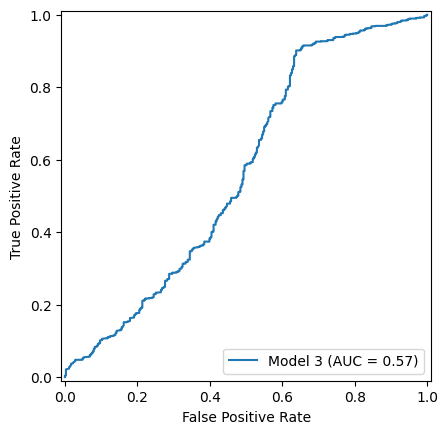

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_true_diag_c25_t, y_prob_diag_c25_t)

roc_auc = metrics.auc(fpr, tpr)

display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='Model 3')
display.plot()

# Discussion


The results of the paper present insights into the use cases for Pancreatic Cancer and international PTSD. However, reproducing these results was challenging due to several factors.

The paper, unfortunately, falls short of being reproducible due to various obstacles encountered during the reproduction process.

Accessing the dataset utilized in the original study presented a significant challenge. The dataset's availability and accessibility were limited, impeding efforts to replicate the paper's findings accurately. This lack of easy access to crucial data hindered the replication process from the outset, highlighting the importance of transparent and readily available datasets for ensuring reproducibility in scientific research.

The absence of direct communication channels with the paper's authors further compounded the challenges faced during reproduction. Unfortunately, the lack of such communication avenues hindered the resolution of ambiguities and obstacles encountered during the reproduction process.

Furthermore, an analysis of the code repository provided alongside the paper revealed critical deficiencies. Key elements essential for reproducing the experiments, such as 'dataset.py' and tokenizer information, were missing from the repository. This incompleteness significantly impeded the replication efforts.

Additionally, attempts to utilize pre-trained tokenizer and models were met with access errors (401), further complicating the reproduction process. These errors likely stemmed from issues related to dependencies or data access permissions.

Though Understanding the paper's conceptual ideas and methodologies and Initial setup and configuration of the reproduction environment is easy. The difficulties of reproducing the result of original paper are - 
* Accessing the dataset and ensuring its compatibility with the provided code.
* Resolving missing elements in the code repository.
* Overcoming access errors while utilizing pre-trained models and tokenizers.
* Adapting to discrepancies in sample sizes between the original dataset and the available dataset. 

Addressing these challenges arrive at reccomneations for concerted efforts to improve data accessibility, enhance communication channels between authors and reproducers, ensure completeness of code repositories, resolve access errors, and maintain consistency in dataset sizes.








# References

1.   Yang, Z., Mitra, A., Liu, W. et al. TransformEHR: transformer-based encoder-decoder generative model to enhance prediction of disease outcomes using electronic health records. Nat Commun 14, 7857 (2023). https://doi.org/10.1038/s41467-023-43715-z



# Feel free to add new sections